<a href="https://colab.research.google.com/github/villifCoder559/VGGFaceFeatures_PCA/blob/main/VGGFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install faiss-cpu --no-cache

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 171.3 MB/s eta 0:00:00


In [2]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install tensorflow keras_applications
!pip install layer_utils

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-u4ps8ytd
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-u4ps8ytd
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8295 sha256=7413d0ea06beae031930c820d1a3513832fa1082497129228aa60f8d09476232
  Stored in directory: /tmp/pip-ephem-wheel-cache-2y1awn9t/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 704.1 kB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement layer_utils (from versions: none)
ERROR: No matching distribution found for layer_utils


In [3]:
!pip install keras==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


In [4]:
import numpy as np
import pandas as pd
import cv2
import keras
from keras_vggface.vggface import VGGFace
from sklearn.datasets import fetch_lfw_people
from skimage.transform import resize
import faiss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd

In [ ]:
!pip install keras_preprocessing

In [5]:
from sklearn.model_selection import train_test_split
faces = fetch_lfw_people(min_faces_per_person=70,resize=2.3,color=True)
X_train, X_test, y_train, y_test = train_test_split(faces.images, faces.target, test_size=0.1, random_state=2)

In [ ]:
nr_images=np.zeros(faces.target_names.shape[0])
i=0
for i in range(faces.target_names.shape[0]):
  nr_images[i]=np.sum(i==faces.target)
  i=i+1
nr_images

array([ 77., 236., 121., 530., 109.,  71., 144.])

In [ ]:
image_samples_train=np.copy(X_train)
image_samples_train=np.array([cv2.resize(img,(224,224)) for img in image_samples_train])
image_samples_train[:,:,:,0]=(image_samples_train[:,:,:,0]-np.mean(X_train[:,:,:,0]))/(np.std(X_train[:,:,:,0]))
image_samples_train[:,:,:,1]=(image_samples_train[:,:,:,1]-np.mean(X_train[:,:,:,1]))/(np.std(X_train[:,:,:,1]))
image_samples_train[:,:,:,2]=(image_samples_train[:,:,:,2]-np.mean(X_train[:,:,:,2]))/(np.std(X_train[:,:,:,2]))

In [ ]:
image_samples_test=np.copy(X_test)
image_samples_test=np.array([cv2.resize(img,(224,224)) for img in image_samples_test])
image_samples_test[:,:,:,0]=(image_samples_test[:,:,:,0]-np.mean(X_train[:,:,:,0]))/(np.std(X_train[:,:,:,0]))
image_samples_test[:,:,:,1]=(image_samples_test[:,:,:,1]-np.mean(X_train[:,:,:,1]))/(np.std(X_train[:,:,:,1]))
image_samples_test[:,:,:,2]=(image_samples_test[:,:,:,2]-np.mean(X_train[:,:,:,2]))/(np.std(X_train[:,:,:,2]))

Possible comparisons pre-processing image after scaling 224x224:
*   Centering and Standardization
*   PCA (no,500,100,20)
*   FlatL2 or FlatIP (faiss)
*   Precision top 5,20,50,all

In [ ]:
vggface = VGGFace(model='vgg16',include_top=False,input_shape=(image_samples_train.shape[1],image_samples_train.shape[2],image_samples_train.shape[3]))
# resized_images=[resize(img,output_shape=(224,224)) for img in faces.images]
result_train=vggface.predict(image_samples_train)
result_test=vggface.predict(image_samples_test)
original_result_train=np.copy(result_train)
original_result_test=np.copy(result_test)

5/5 [==============================] - 2s 376ms/step


In [6]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/'
# np.save(os.path.join(drive_path, 'faces.npy'), faces)
# np.save(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_train.npy'), original_result_train)
# np.save(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_test.npy'), original_result_test)

Mounted at /content/drive


In [7]:
import os
drive_path = '/content/drive/MyDrive/'
result_train=np.load(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_train.npy'),allow_pickle=True)
result_test=np.load(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_test.npy'),allow_pickle=True)

In [28]:
features_vectorized=result_train.reshape(result_train.shape[0],-1)
# features_vectorized=np.ascontiguousarray(features_vectorized)

In [8]:
def create_test_reduction(n_components,result_train):
  features_reducted=result_train.reshape(result_train.shape[0],-1)
  if n_components > 0:
    tmp_PCA=PCA(n_components=n_components)
    features_reducted=np.ascontiguousarray(tmp_PCA.fit_transform(features_reducted))
  else:
    tmp_PCA=PCA(n_components=100).fit(features_reducted)
    features_reducted=custom_reduction(tmp_PCA,result_train,n_components)
  faiss.normalize_L2(features_reducted)
  return tmp_PCA,features_reducted,faiss.IndexFlatIP(features_reducted.shape[1])

In [9]:
def custom_reduction(pca,result_train,start_index):
  transformed_results = []
  for element in result_train:
    test = element.reshape(1, -1)
    # Apply PCA transformation
    transformed_result = np.dot(test - pca.mean_, pca.components_[(-start_index):].T)
    transformed_results.append(transformed_result)
  return np.array(transformed_results).reshape(result_train.shape[0],pca.components_.shape[0]+start_index)

In [10]:
pca_objs=[]
list_n_components=[0,15,100,500,-3] #0 -> No PCA, -K -> Without first K eigenvectors, +K -> Use K components
features_objs=[]
index_faiss_objs=[]
for n_components in list_n_components:
  if n_components>0:
    pca,features,index=create_test_reduction(n_components,result_train)
    pca_objs.append(pca)
    features_objs.append(features)
    index_faiss_objs.append(index)
  else:
    if(n_components<0):
      pca,features,index=create_test_reduction(n_components,result_train)
      pca_objs.append(pca)
      features_objs.append(features)
      index_faiss_objs.append(index)
    else: # dummy PCA
      pca_objs.append(PCA())
      features_objs.append(result_train.reshape(result_train.shape[0],-1))
      index_faiss_objs.append(faiss.IndexFlatIP(result_train.reshape(result_train.shape[0],-1).shape[1]))
#add vectors to index
count=0
for index in index_faiss_objs:
  print(features_objs[count].shape)
  index.add(features_objs[count])
  count=count+1

(1159, 25088)
(1159, 15)
(1159, 100)
(1159, 500)
(1159, 97)


In [11]:
def compute_precision_recall(ground_truth,retrived_indices_faiss,target,retrive_all=False):
  retrived_targets_id=ground_truth[retrived_indices_faiss]
  TP=np.count_nonzero(retrived_targets_id==target)
  total_samples=np.sum(ground_truth==target)
  FP=retrived_indices_faiss.shape[1]-TP
  precision=0
  if TP+FP!=0:
    precision=TP/(TP+FP)
  recall=TP/(TP+(total_samples-TP))
  return precision,recall

In [12]:
list_top_elements=[5]
i=0
j=0
k=0
precision_results=[]
recall_results=[]
name_results=[]
list_precision_results=[]
list_recall_results=[]
test_vectors=result_test.reshape(result_test.shape[0],-1)
# vector=result_test[count]
for top_k in list_top_elements:
  for index in index_faiss_objs:
    for vector in test_vectors:
      if list_n_components[i] > 0:
        reduced_vector=(vector.reshape(1,-1)-pca_objs[i].mean_)@pca_objs[i].components_.T
      else:
        if list_n_components[i] < 0:
          reduced_vector=(vector.reshape(1,-1)-pca_objs[i].mean_)@pca_objs[i].components_[-list_n_components[i]:].T
        else:
          reduced_vector=vector
      _,retrived_elements=index.search((reduced_vector.reshape(1, -1)), top_k)
      precision,recall=compute_precision_recall(y_train,retrived_elements,y_test[j])
      name_results.append(y_test[j])
      precision_results.append(precision)
      recall_results.append(recall)
      j=j+1
    i=i+1
    j=0
recall_results=np.array(recall_results).reshape(len(list_top_elements),len(index_faiss_objs),test_vectors.shape[0])
precision_results=np.array(precision_results).reshape(len(list_top_elements),len(index_faiss_objs),test_vectors.shape[0])
name_results=np.array(name_results).reshape(len(list_top_elements),len(index_faiss_objs),test_vectors.shape[0])

In [66]:
np.bincount(selected_name_result,weights=selected_precision_result)

array([ 8. , 37. ,  7.6, 41.8,  6.4,  8.6, 11. ])

In [24]:
recall_results.shape

(1, 5, 129)

In [30]:
index_selected_top_k_retrival = 0 # precision_results.shape[0]
index_faiss_n_components = 4 # precision_results.shape[1]
if(index_selected_top_k_retrival<=precision_results.shape[0] and index_faiss_n_components<=precision_results.shape[1]):
  selected_name_result=name_results[index_selected_top_k_retrival][index_faiss_n_components]
  selected_recall_result=recall_results[index_selected_top_k_retrival][index_faiss_n_components]
  selected_precision_result=precision_results[index_selected_top_k_retrival][index_faiss_n_components]
  id_labels,normalization_factors=np.unique(y_test,return_counts=True)
else:
  if index_selected_top_k_retrival>precision_results.shape[0]:
    print('ERROR: index_selected_top_k_retrival must be <',precision_results.shape[0])
  if index_faiss_n_components>precision_results.shape[1]:
    print('ERROR: index_faiss_n_components must be <',precision_results.shape[1])

In [31]:
df = pd.DataFrame({
    "Faces":id_labels,
    "Prec.":np.bincount(selected_name_result,weights=selected_precision_result)/normalization_factors,
    "Rec.":np.bincount(selected_name_result,weights=selected_recall_result)/normalization_factors,
})
df=df.round(decimals=2)
print('Top',list_top_elements[index_selected_top_k_retrival],"PCA nr",list_n_components[index_faiss_n_components])
df

Top 5 PCA nr -3


,Faces,Prec.,Rec.
0,0,1.00,0.07
1,1,0.97,0.02
2,2,1.00,0.04
3,3,0.97,0.01
4,4,0.94,0.05
5,5,0.91,0.07
6,6,0.98,0.04


In [21]:
df = pd.DataFrame({
    "Faces":id_labels,
    "Prec.":np.bincount(selected_name_result,weights=selected_precision_result)/normalization_factors,
    "Rec.":np.bincount(selected_name_result,weights=selected_recall_result)/normalization_factors,
})
df=df.round(decimals=2)
print('Top',list_top_elements[index_selected_top_k_retrival],"PCA nr",list_n_components[index_faiss_n_components])
df

Top 5 PCA nr 15


,Faces,Prec.,Rec.
0,0,1.00,0.07
1,1,1.00,0.03
2,2,1.00,0.04
3,3,0.99,0.01
4,4,0.98,0.05
5,5,0.96,0.08
6,6,0.94,0.04


In [69]:
print(index_selected_top_k_retrival)
print(index_faiss_n_components)
precision_results[index_selected_top_k_retrival][index_faiss_n_components]

0
0


array([1. , 1. , 1. , 1. , 0.4, 1. , 1. , 1. , 1. , 0.8, 1. , 1. , 0.4,
       1. , 0.8, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 0.6, 1. , 0.2, 1. , 1. , 0.6, 1. , 1. , 0.8, 1. ,
       1. , 0. , 0.8, 1. , 1. , 0.6, 1. , 0.8, 1. , 0.8, 1. , 1. , 1. ,
       1. , 0.6, 1. , 0.8, 1. , 0.8, 1. , 0.8, 0.8, 1. , 1. , 1. , 1. ,
       1. , 1. , 0.8, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 0.8, 1. , 0.6, 1. , 1. , 1. , 1. , 0.8, 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 0.6, 1. , 1. , 1. , 1. , 0.8, 1. , 1. ,
       1. , 1. , 1. , 1. , 0.6, 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

In [91]:
precision_results[index_selected_top_k_retrival][index_faiss_n_components][tmp]

array([1. , 0.8, 0.8, 0.8, 1. , 1. , 1. , 1. , 0.6])

In [90]:
tmp=np.array([val==0 for val in y_test])
tmp

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [29]:
pca=PCA(n_components=20)
features_reduction=np.ascontiguousarray(pca.fit_transform(features_vectorized))
features_reduction.astype(np.float32)

index_faiss=faiss.IndexFlatIP(features_reduction.shape[1])
faiss.normalize_L2(features_reduction) # IMPORTANT, it improves much the alg. !!
index_faiss.add(features_reduction)

In [ ]:
index_faiss=faiss.IndexFlatL2(features_vectorized.shape[1])
faiss.normalize_L2(features_vectorized) # IMPORTANT, it improves much the alg. !!
index_faiss.add(features_vectorized)

In [67]:
def get_list_results(results,y_test):
  id_results,normalization_factors=np.unique(y_test,return_counts=True)
  return np.bincount(name_results,weights=results)/normalization_factors

In [30]:
list_top_elements=[5,50]
i=0
j=0
precision_results=[]
recall_results=[]
name_results=[]
list_precision_results=[]
list_recall_results=[]
# vector=result_test[count]
for k in list_top_elements:
  for vector in result_test:
    reduced_vector=(vector.reshape(1,-1)-pca.mean_)@pca.components_.T
    _,retrived_elements=index_faiss.search(reduced_vector.reshape(1, -1), k)
    precision,recall=compute_precision_recall(y_train,retrived_elements,y_test[i])
    name_results.append(y_test[i])
    precision_results.append(precision)
    recall_results.append(recall)
    i=i+1
  i=0
  list_precision_results.append(get_list_results(precision_results,y_test))
  list_recall_results.append(get_list_results(recall_results,y_test))
  j=j+1
  precision_results=[]
  recall_results=[]
  name_results=[]
  # break
list_precision_results=np.array(list_precision_results).reshape(len(list_top_elements),faces.target_names.shape[0])
list_recall_results=np.array(list_recall_results).reshape(len(list_top_elements),faces.target_names.shape[0])

In [34]:
name_results

[]

In [33]:
df = pd.DataFrame({
    "Faces":range(0,7),
    "Prec.":np.bincount(name_results,weights=precision_results)/normalization_factors,
    "Rec.":np.bincount(name_results,weights=recall_results)/normalization_factors,
})
df=df.round(decimals=2)
print('@'+str(k),"Results 20 PCA_components")
df

ValueError: operands could not be broadcast together with shapes (0,) (7,) 

In [35]:
df = pd.DataFrame({
    "Faces":name_results,
    "Prec.":precision_results,
    "Rec.":recall_results,
})
df=df.round(decimals=2)
print("Results 20 PCA_components")
df

Results 20 PCA_components


,Faces,Prec.,Rec.


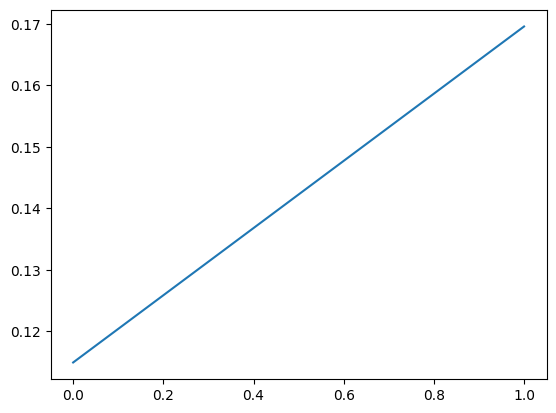

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_[:2]))

In [36]:
def get_precision_recall(ground_truth,feature_vector,get_k_elemets):
  precision = 0
  recall = 0
  precision_results = []
  recall_results = []
  count=1
  TP=0
  FP=0
  len_ground_truth=get_k_elemets
  if get_k_elemets==-1:
    get_k_elemets=len(ground_truth)*count*2
    len_ground_truth=len(ground_truth)
  FN=len_ground_truth-TP
  k=1
  start_from=0
  while recall != 1:
    _,results_index=index_faiss.search(feature_vector,get_k_elemets*count)
    tmp=results_index[0][start_from:]
    verification_vector=np.isin(tmp,ground_truth).reshape(-1)
    for res in verification_vector:
      if res:
        TP=TP+1
      else:
        FP=FP+1
      FN = len_ground_truth - TP
      if TP + FP != 0:
        precision = TP / (TP+FP)
      if TP + FN != 0:
        recall = TP / (TP+FN)
      precision_results.append(precision)
      recall_results.append(recall)
      if recall==1:
        print('RECALL')
        break;
    # if get_k_elemets != -1:
    #   break
    start_from = len_ground_truth*count
    count = count + 1
  print('precision ',precision)
  print('recall ',recall)
  return precision_results,recall_results

In [37]:
precision_results=[]
recall_results=[]
auc_results=[]
precision_last_value_results=[]
recall_last_value_results=[]
F1_results=[]
get_top_k=-1
elemets_to_retrive=faces.target_names
for index in range(elemets_to_retrive.shape[0]):
  precisions = []
  recalls = []
  ground_truth=np.where(faces.target==index)[0]
  print(faces.target_names[index])
  precision,recall=get_precision_recall(ground_truth.reshape(-1),features_reduction,get_top_k)
  print('')
  precision_results.append(precision)
  recall_results.append(recall)
  precision_last_value_results.append(precision[-1])
  recall_last_value_results.append(recall[-1])
  auc_results.append(metrics.auc(recall,precision))
  F1_results.append((2*precision[-1]*recall[-1]/(precision[-1]+recall[-1])))
  # print(index)
  # print(faces.target_names[index])
  # print(auc_results[index])
  # break

Ariel Sharon
RECALL
precision  0.060821484992101105
recall  1.0

Colin Powell
RECALL
precision  0.1782477341389728
recall  1.0

Donald Rumsfeld
RECALL
precision  0.10512597741094701
recall  1.0

George W Bush
RECALL
precision  0.41568627450980394
recall  1.0

Gerhard Schroeder
RECALL
precision  0.08128262490678598
recall  1.0

Hugo Chavez
RECALL
precision  0.062280701754385964
recall  1.0

Tony Blair
RECALL
precision  0.11311861743912019
recall  1.0



In [38]:
df = pd.DataFrame({
    "Faces":faces.target_names,
    "Rec.":recall_last_value_results,
    "Prec.":precision_last_value_results,
    "AUC":auc_results
})
df=df.round(decimals=2)
print("Results No (PCA and normalized)")
df

Results No (PCA and normalized)


,Faces,Rec.,Prec.,AUC
0,Ariel Sharon,1.0,0.06,0.07
1,Colin Powell,1.0,0.18,0.18
2,Donald Rumsfeld,1.0,0.11,0.11
3,George W Bush,1.0,0.42,0.39
4,Gerhard Schroeder,1.0,0.08,0.08
5,Hugo Chavez,1.0,0.06,0.06
6,Tony Blair,1.0,0.11,0.11


In [ ]:
df = pd.DataFrame({
    "Faces":faces.target_names,
    "Rec.":recall_last_value_results,
    "Prec.":precision_last_value_results,
    "AUC":auc_results
})
df=df.round(decimals=2)
print("Results No (PCA and normalized)")
df

Results No (PCA and normalized)


,Faces,Rec.,Prec.,AUC
0,Ariel Sharon,1.0,0.50,0.97
1,Colin Powell,1.0,0.48,0.90
2,Donald Rumsfeld,1.0,0.49,0.95
3,George W Bush,1.0,0.47,0.90
4,Gerhard Schroeder,1.0,0.26,0.73
5,Hugo Chavez,1.0,0.43,0.70
6,Tony Blair,1.0,0.32,0.87


In [ ]:
df = pd.DataFrame({
    "Faces":faces.target_names,
    "Rec.":recall_last_value_results,
    "Prec.":precision_last_value_results,
    "AUC":auc_results
})
df=df.round(decimals=2)
print("Results No (PCA and normalized)")
df

Results No (PCA and normalized)


,Faces,Rec.,Prec.,AUC
0,Ariel Sharon,1.0,0.75,0.98
1,Colin Powell,1.0,0.43,0.90
2,Donald Rumsfeld,1.0,0.16,0.94
3,George W Bush,1.0,0.42,0.87
4,Gerhard Schroeder,1.0,0.15,0.76
5,Hugo Chavez,1.0,0.17,0.56
6,Tony Blair,1.0,0.20,0.88


[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]

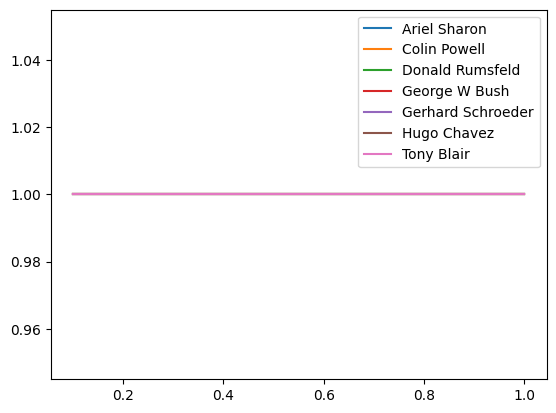

In [ ]:
for i in range(7):
  plt.plot(recall_results[i],precision_results[i],label=faces.target_names[i])
plt.legend()
auc_results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# flattened_list = [item.flatten() for item in faces]
# Define the file path
file_path = '/content/drive/MyDrive/vgg_original_features'
# Open the file in write mode or create it if it doesn't exist
with open(file_path, 'w+') as file:
    # Write each flattened element of the list to a new line
    for item in result:
        file.write(','.join(map(str, item)) + '\n')

# Print a message indicating that the file has been saved
print(f'List saved to {file_path}')

List saved to /content/drive/MyDrive/vgg_original_features
